In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter
# from matplotlib.colors import LogNorm
import numpy as np
import math as ma
from subprocess import call

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

from scipy.io import readsav
from scipy.interpolate import interp1d
# from scipy.interpolate import interp2d

import extinction
import igm

import loadSP as lsp
import cosmo
import halos
# import logInterp 

plt.rcParams['figure.figsize'] = (13,11)
# plt.rcParams['font.size'] = 32
plt.rcParams.update({'font.size': 18, 'font.family': 'serif'})
import gc

In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')

def div_formatter(x,pos):
    return format(x/1000, '.1f')

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)
divfmt  = FuncFormatter(div_formatter)
logfmt  = FuncFormatter(log_formatter)
nullfmt = NullFormatter()

In [88]:
# Cosmology from my paper
myCosmo = FlatLambdaCDM(H0=71.0, Om0=0.267, Ob0=0.0449, name='myCosmo')
# Make sure we have halo information for this z... hop/...
num = 43 # This is the output_00num file that has the "info_" for finding the boxsize... see map above.
z   = 12.0

print("Using astropy cosmology: physical size {:.2f}".format((3 * u.Mpc/(1.0+z) * 1/0.71).to(u.kpc)))

sizeKeys = np.loadtxt('zKeysForSPfiles.txt',skiprows=1)
print("Physical Boxsize from kKey file = {}".format(sizeKeys[sizeKeys[::,0] == z][0,1] * u.kpc))
boxsizekpc = sizeKeys[sizeKeys[::,0] == z][0,1]

rho_critDMz = myCosmo.critical_density(z) * myCosmo.Odm(z)
print('rho_critdm,z = {:.3e}'.format(rho_critDMz))

gc.collect()

Using astropy cosmology: physical size 325.03 kpc
Physical Boxsize from kKey file = 324.44 kpc
rho_critdm,z = 4.621e-27 g / cm3


22

In [89]:
Odm = 0.222 # Om - Ob = Odm
h0  = 0.71
rho0 = myCosmo.critical_density0 * Odm # rho0 * O_DM --- Crit density in DM TODAY... Need to scale to redshift.
rho0/Odm
# Looks correct!

<Quantity 9.469372730554712e-30 g / cm3>

In [90]:
dmPartMass = 5.58e4 * Odm / h0 * u.Msun
print("DM particle mass {:.2f}".format(dmPartMass))
def totMass(numParts):
    return dmPartMass * numParts

DM particle mass 17447.32 solMass


In [91]:
# Example computation... 
haloTotMass = dmPartMass * 50863 # Number of DM particles, 0004Halo 0, z=12
overDens = 100.0
size = ((haloTotMass * 3.0/(4.0 * ma.pi) * 1.0/(rho_critDMz * overDens))**(1.0/3.0)).to(u.kpc) * (1 + z)
# size = size * 0.5
size

<Quantity 40.85630933965904 kpc>

In [92]:
##############################################
# Load the star particle positions. 
# locsRaw is in physical kpc
##############################################
locsRaw, mass, bt, Z, PZ, PPF = lsp.loadSP(z)

##############################################
# Need to correct the Z and PZ for the pristine
# fraction of the SP... 
##############################################
fpol = 1.0-PPF
fpol[fpol < 1e-5] = 0.0 # Don't form polluted stars when fpol is very small

Z_corr = Z/fpol
Z_corr[np.isinf(Z_corr)] = 0.9e-5 # Make the Z of the particles < Z_crit (1e-5)
Z_corr[Z_corr < 1e-5]    = 0.9e-5 # Place them all just below Z_crit
gc.collect()

/Users/earnric/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in true_divide


36

In [93]:
3000/h0

4225.352112676057

(-0.51, 0.51)

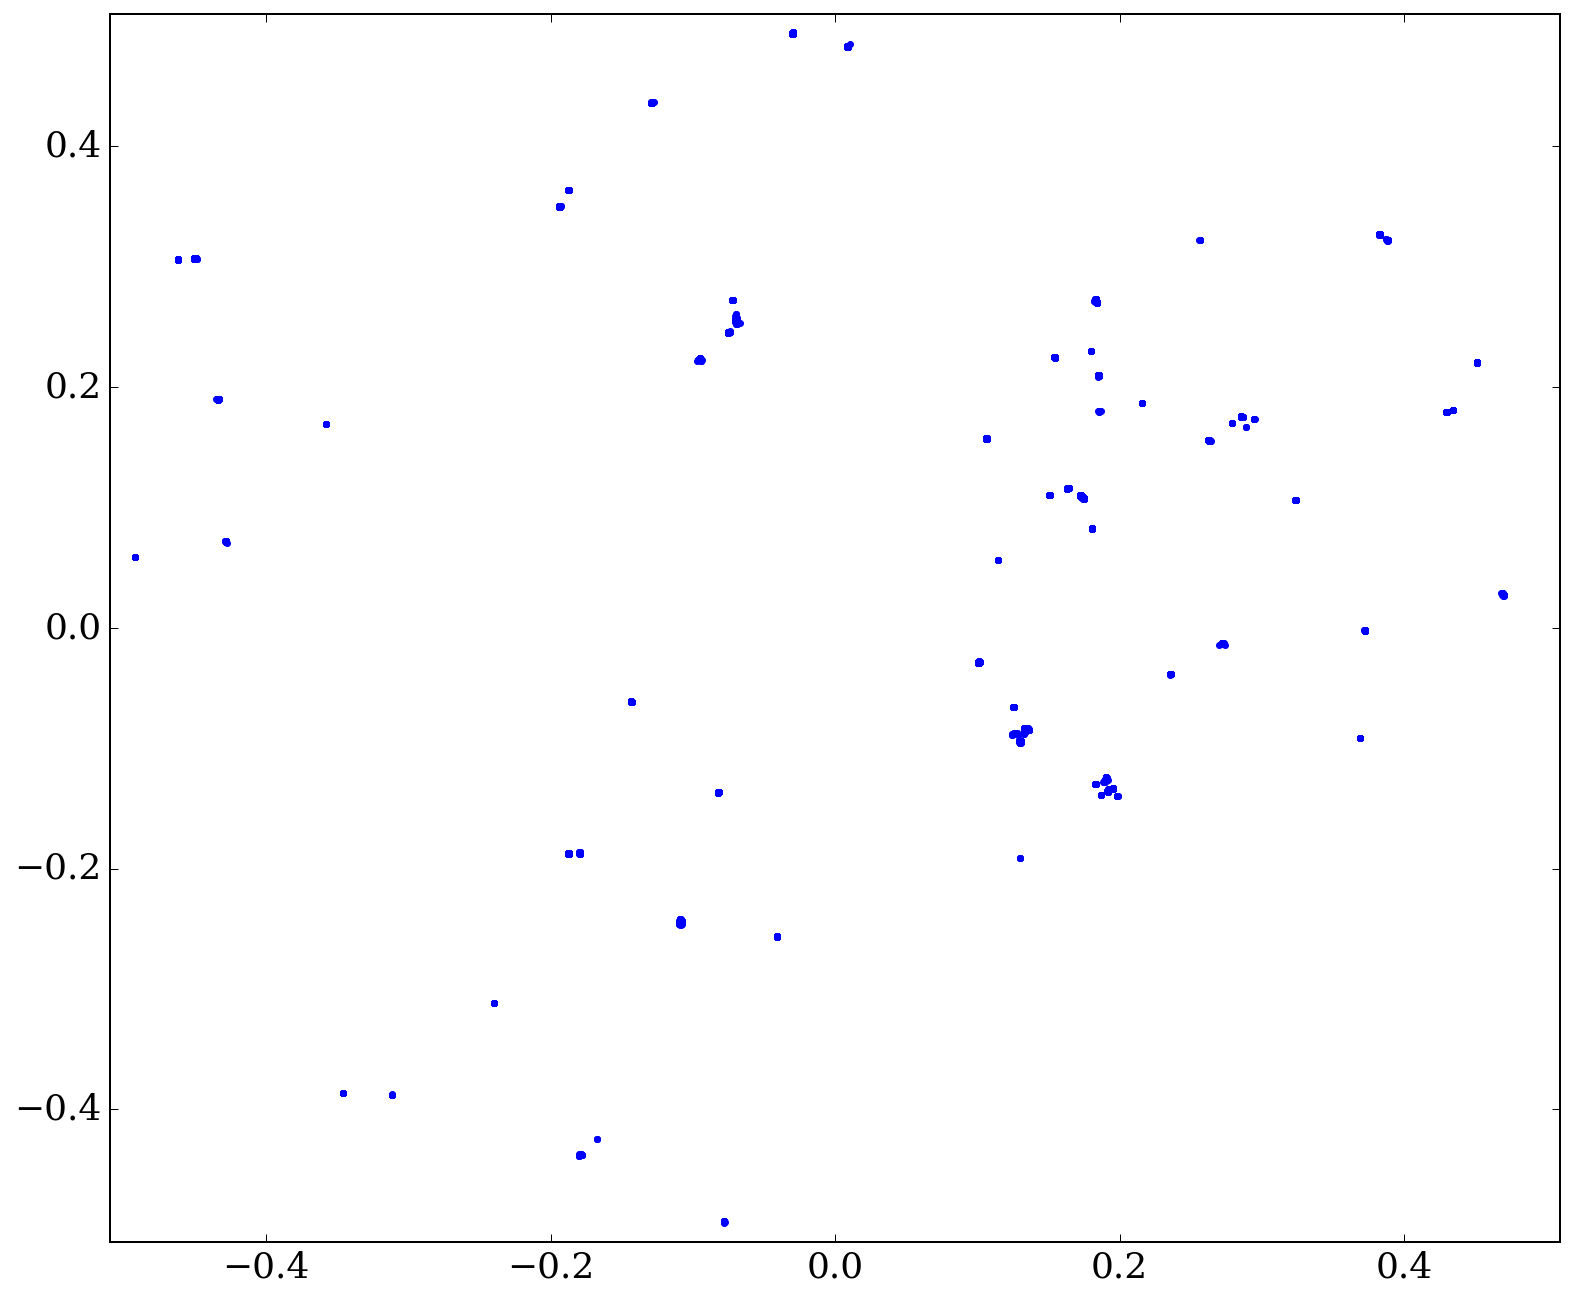

In [101]:
# Plot stars using unit-box-len coordinates

plt.plot((locsRaw/boxsizekpc)[:,0],(locsRaw/boxsizekpc)[:,1],'b.')
plt.xlim([-.51,.51])
plt.ylim([-.51,.51])

In [69]:
# Box len, kpc co-moving
print("Box size, comoving = {:.2f} kpc".format(3000/h0))

Box size, comoving = 4225.35 kpc


In [65]:
max(locs[:,0].max(),locs[:,1].max(),locs[:,2].max())

1056.3366499934959

In [105]:
# Map the range -0.5 to 0.5 to -1500/h to 1500/h kpc comoving per h
locs = (locsRaw/boxsizekpc) * 3000.0 # add '/h0' to get comoving without "per h"

In [71]:
# Compute age of the star particles...
# spAges is in Myr ... 

baseAge = cosmo.ageAtz(71,z) # ageAtZ return Myr, parameters are H and z
print("base age {:.2f}".format(baseAge))
spAges = baseAge - bt/1e6    # bt from SP file is in yr, convert to Myr... 
print("min sp age {:.2f} Myr".format(min(spAges)))
print("max sp age {:.2f} Myr".format(max(spAges)))
print("min sp Z {:.2e} Solar".format(min(Z)))
print("max sp Z {:.2e} Solar".format(max(Z)))
print("max sp Z {:.2e} mass frac".format(max(Z) * 0.02))

base age 562.01
min sp age 1.59 Myr
max sp age 362.90 Myr
min sp Z 5.00e-09 Solar
max sp Z 2.32e-01 Solar
max sp Z 4.64e-03 mass frac


In [72]:
arcPerKpc = myCosmo.arcsec_per_kpc_comoving(z=z)
print('Comoving @ {}, {:.4f}:'.format(z,arcPerKpc))
arcPerKpc = myCosmo.arcsec_per_kpc_proper(z=z)
print('Proper to {}, {:.4f}:'.format(z,arcPerKpc))
print('Proper to {}, {:.4f}:'.format(z,1/arcPerKpc))

kpcPerArcSec = cosmo.arcAtz(71,z=z,om=0.267) # size of an arcsec at the specified reshift in kpc
print('My Comoving @ {}, {:.4f}:'.format(z,arcPerKpc/(1+z)))
print('My Proper to {}, {:.4f}:'.format(z,arcPerKpc))
print('My Proper to {}, {:.4f}:'.format(z,1/arcPerKpc))

Comoving @ 9.0, 0.0218 arcsec / kpc:
Proper to 9.0, 0.2181 arcsec / kpc:
Proper to 9.0, 4.5855 kpc / arcsec:
My Comoving @ 9.0, 0.0218 arcsec / kpc:
My Proper to 9.0, 0.2181 arcsec / kpc:
My Proper to 9.0, 4.5855 kpc / arcsec:


In [73]:
myCosmo.age(z)

<Quantity 0.5591945170082897 Gyr>

In [75]:
##
## Load the halo locations
## hop halo pos file key:    #   npart,mass,cont.frac,xc,yc,zc,uc,vc,wc
## Scale locations to co-moving coordates
## ## ## GET FROM hopRick - STAR PARTICLE BASED HALOS ## ## ##
## ## ## GET FROM hop - DM BASED HALOS ## ## ##
##
halosRawPosStar = lsp.loadHaloGrps(num,prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/hopRick/') # Returns positions normalized to (-0.5, 0.5)
halossizesStar = lsp.loadHaloSizes(num,prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/hopRick/') # Returns positions normalized to (-0.5, 0.5)
halosRawPosDM = lsp.loadHaloGrps(num,prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/hop/') # Returns positions normalized to (-0.5, 0.5)
halossizesDM = lsp.loadHaloSizes(num,prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/hop/') # Returns positions normalized to (-0.5, 0.5)

#halosPos = halosRawPos * boxsizekpc
halosPosStar = halosRawPosStar * 3000.0 # Comoving box per h
halosPosDM = halosRawPosDM * 3000.0 # Comoving box per h
print("Num of star particle based halos @ {} = {}".format(z,len(halosPosStar)))
print("Num of DM based halos @ {} = {}".format(z,len(halosPosDM)))

Num of star particle based halos @ 9.0 = 208
Num of DM based halos @ 9.0 = 3151


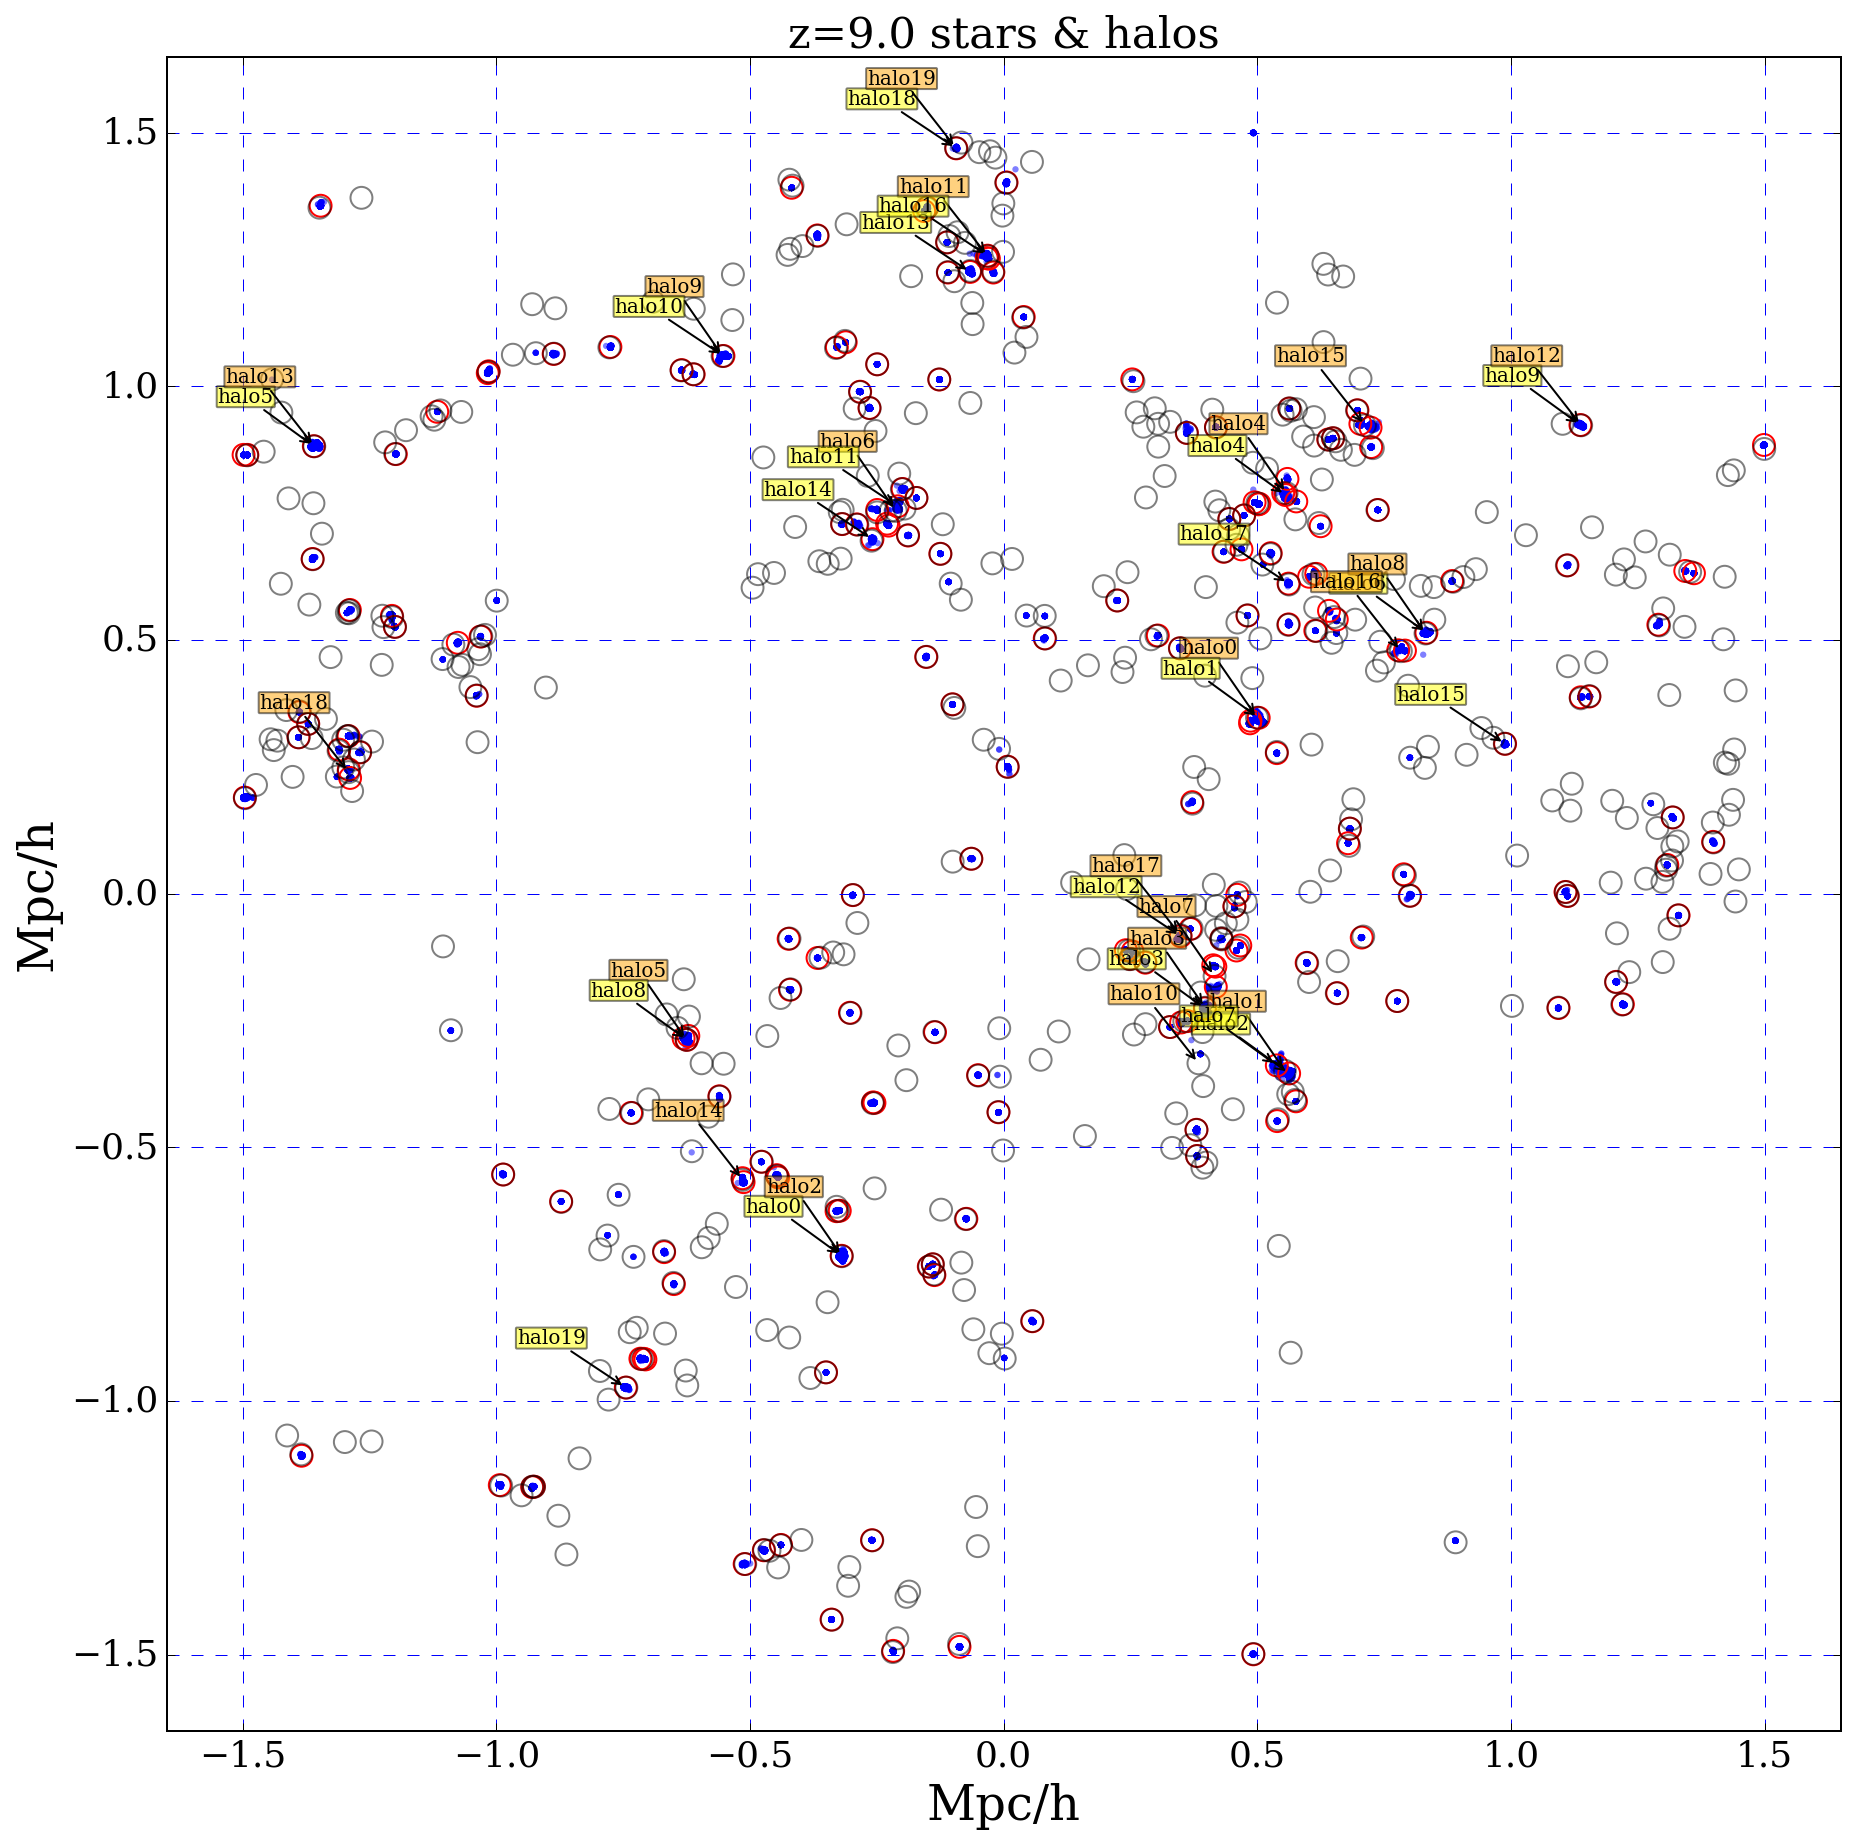

6943

In [78]:
htpS  = len(halosRawPosStar)
htpDM = 500 # len(halosRawPosDM)
plt.figure(figsize=(15,15))
# Generate a set of labels... 
labels = ['halo{0}'.format(i) for i in range(len(halosPosDM))]

# Plot the star particle locations
plt.scatter(locs[:,0]/1000,locs[:,1]/1000,s=10,c='b',edgecolors='None', alpha=0.5) # Plot star particles

# Plot halo locations ... Convert to Mpc
plt.scatter(halosPosStar[:htpS,0]/1000,halosPosStar[:htpS,1]/1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.scatter(halosPosDM[:htpDM,0]/1000,halosPosDM[:htpDM,1]/1000,s=120,facecolors='none', edgecolors='k', alpha=0.5) # Plot halo locs

plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('Mpc/h',fontsize=24)
plt.ylabel('Mpc/h',fontsize=24)

plt.xlim([-1.65,1.65])
plt.ylim([-1.65,1.65])

plt.title('z=%.1lf stars & halos'%z)
for label, xS, yS, xDM, yDM in zip(labels, halosPosStar[:htpS,0][:20]/1000,halosPosStar[:htpS,1][:20]/1000,
                          halosPosDM[:htpDM,0][:20]/1000,halosPosDM[:htpDM,1][:20]/1000):
    plt.annotate(
        label, 
        xy = (xS, yS), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.annotate(
        label, 
        xy = (xDM, yDM), xytext = (-10, 30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'orange', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()
gc.collect()
 

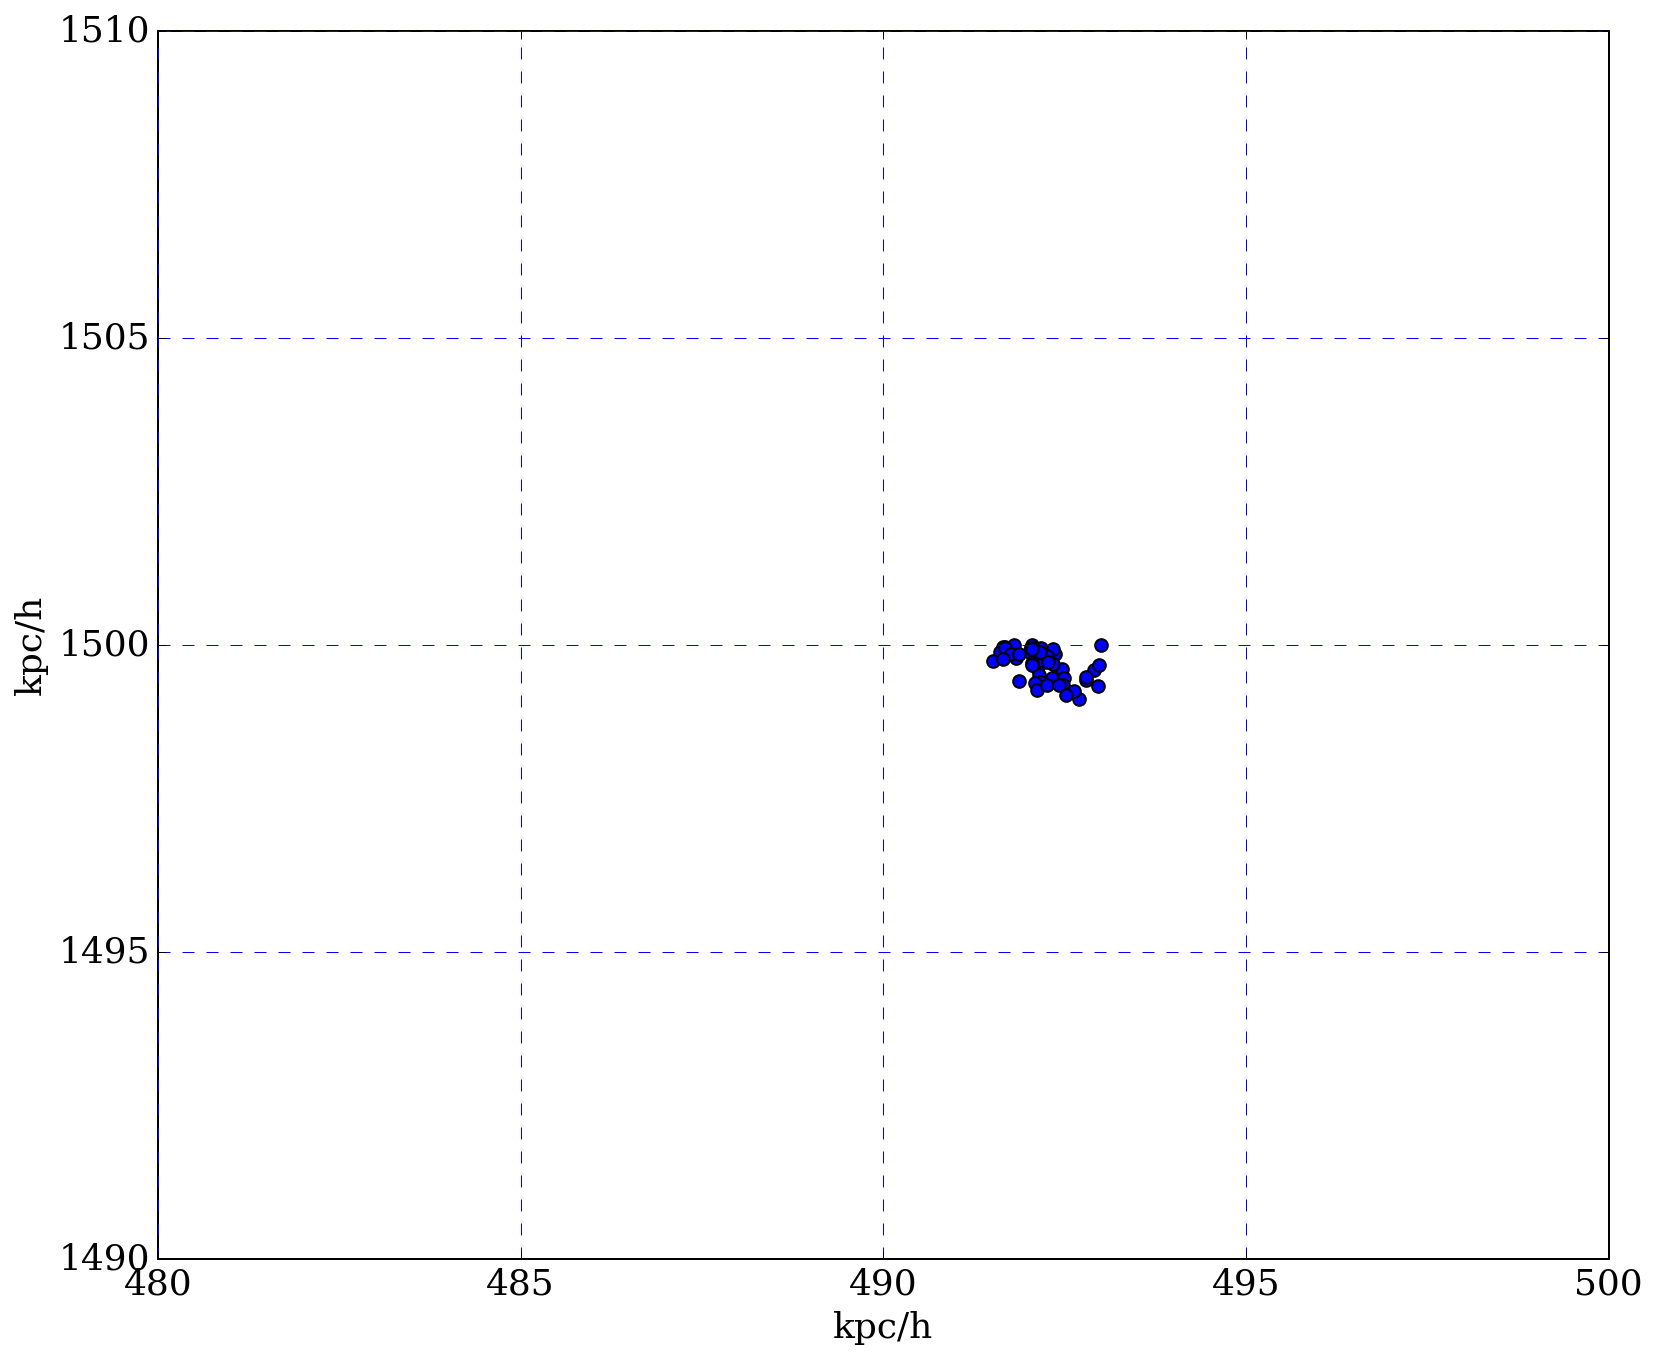

3642

In [84]:
# For 9.0 abandoned halo ... 

plt.scatter(locs[:,0],locs[:,1],s=40,c='b') # Plot star particles

plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('kpc/h')
plt.ylabel('kpc/h')
plt.xlim([480,500])
plt.ylim([1490,1510])
plt.show()
gc.collect()
 

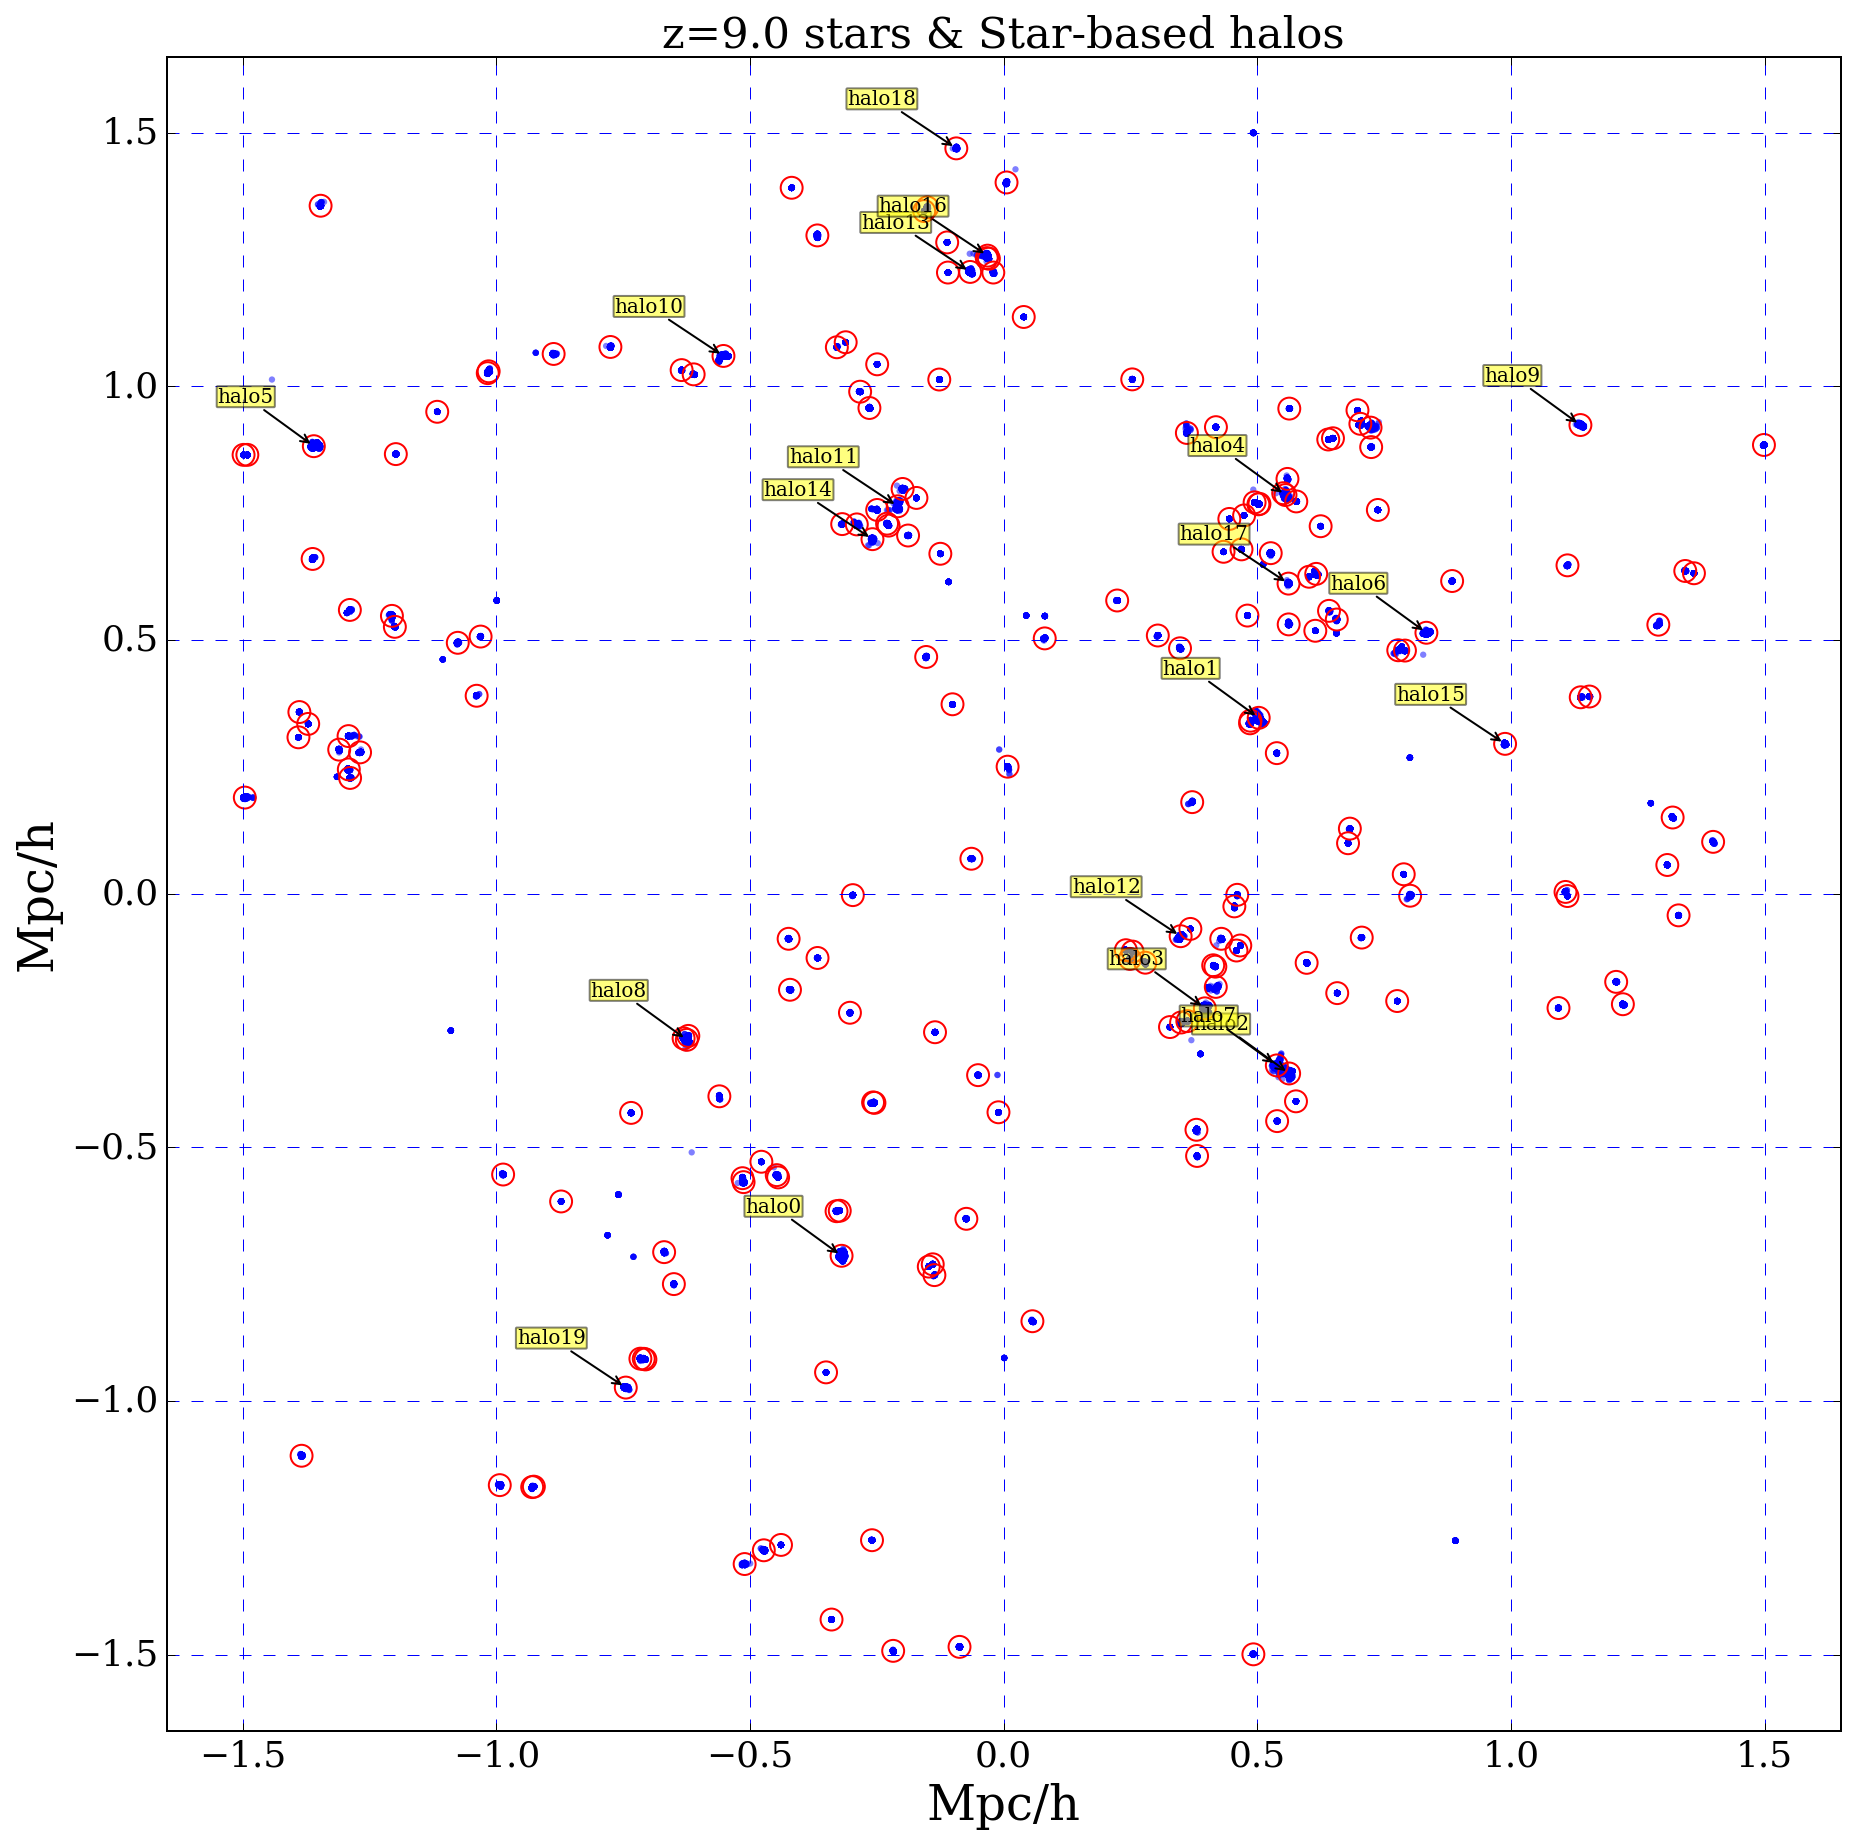

5811

In [86]:
htpS  = len(halosRawPosStar)
plt.figure(figsize=(15,15))
# Generate a set of labels... 
labels = ['halo{0}'.format(i) for i in range(len(halosPosDM))]

# Plot the star particle locations
plt.scatter(locs[:,0]/1000,locs[:,1]/1000,s=10,c='b',edgecolors='None', alpha=0.5) # Plot star particles

# Plot halo locations ... Convert to Mpc
plt.scatter(halosPosStar[:htpS,0]/1000,halosPosStar[:htpS,1]/1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs

plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('Mpc/h',fontsize=24)
plt.ylabel('Mpc/h',fontsize=24)

plt.xlim([-1.65,1.65])
plt.ylim([-1.65,1.65])

plt.title('z=%.1lf stars & Star-based halos'%z)
for label, xS, yS in zip(labels, halosPosStar[:htpS,0][:20]/1000,halosPosStar[:htpS,1][:20]/1000):
    plt.annotate(
        label, 
        xy = (xS, yS), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()
gc.collect()
 

number of halos 3151


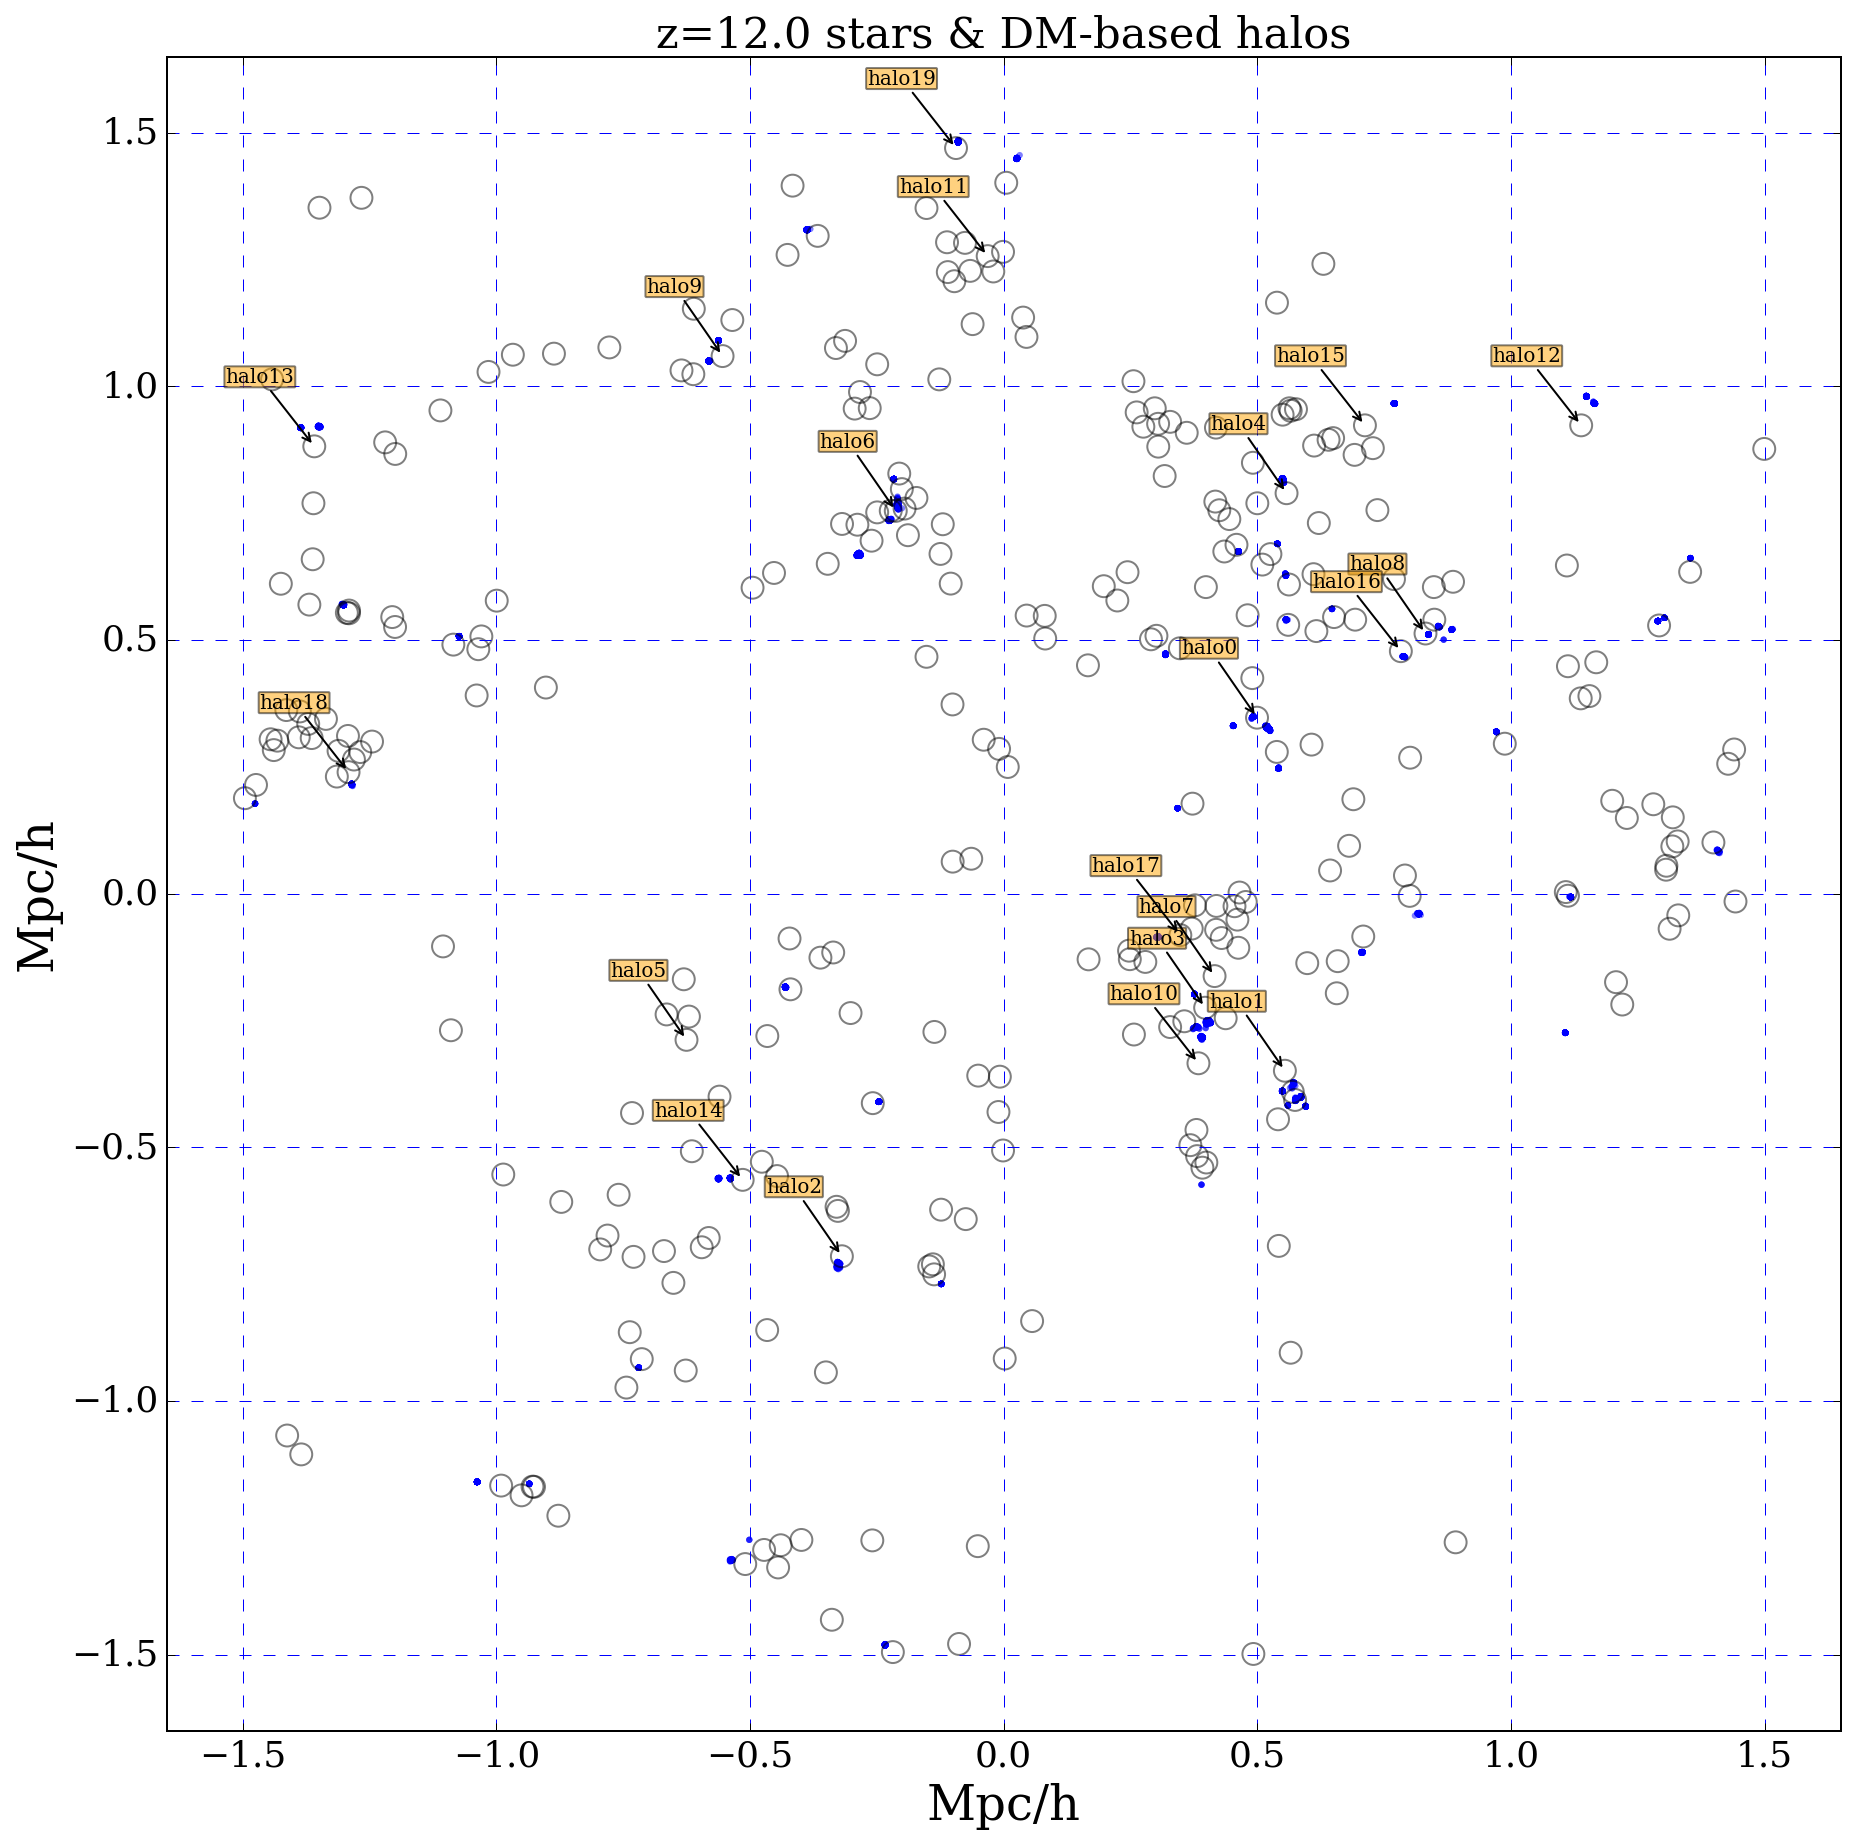

5811

In [107]:
htpDM = 300 # len(halosRawPosDM)
print("number of halos",len(halosRawPosDM))
plt.figure(figsize=(15,15))
# Generate a set of labels... 
labels = ['halo{0}'.format(i) for i in range(len(halosPosDM))]

# Plot the star particle locations
plt.scatter(locs[:,0]/1000,locs[:,1]/1000,s=10,c='b',edgecolors='None', alpha=0.5) # Plot star particles

# Plot halo locations ... Convert to Mpc
plt.scatter(halosPosDM[:htpDM,0]/1000,halosPosDM[:htpDM,1]/1000,s=120,facecolors='none', edgecolors='k', alpha=0.5) # Plot halo locs

plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('Mpc/h',fontsize=24)
plt.ylabel('Mpc/h',fontsize=24)

plt.xlim([-1.65,1.65])
plt.ylim([-1.65,1.65])

plt.title('z=%.1lf stars & DM-based halos'%z)
for label, xDM, yDM in zip(labels, halosPosDM[:htpDM,0][:20]/1000,halosPosDM[:htpDM,1][:20]/1000):
    plt.annotate(
        label, 
        xy = (xDM, yDM), xytext = (-10, 30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'orange', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()
gc.collect()
 

In [102]:
halosRawPosSTDDM = lsp.loadHaloGrps(num,prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/hopSTD/') # Returns positions normalized to (-0.5, 0.5)
halossizesSTDDM = lsp.loadHaloSizes(num,prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/hopSTD/') # Returns positions normalized to (-0.5, 0.5)

#halosPos = halosRawPos * boxsizekpc
halosPosSTDDM = halosRawPosSTDDM * 3000.0 # Comoving box per h


number of halos 3326


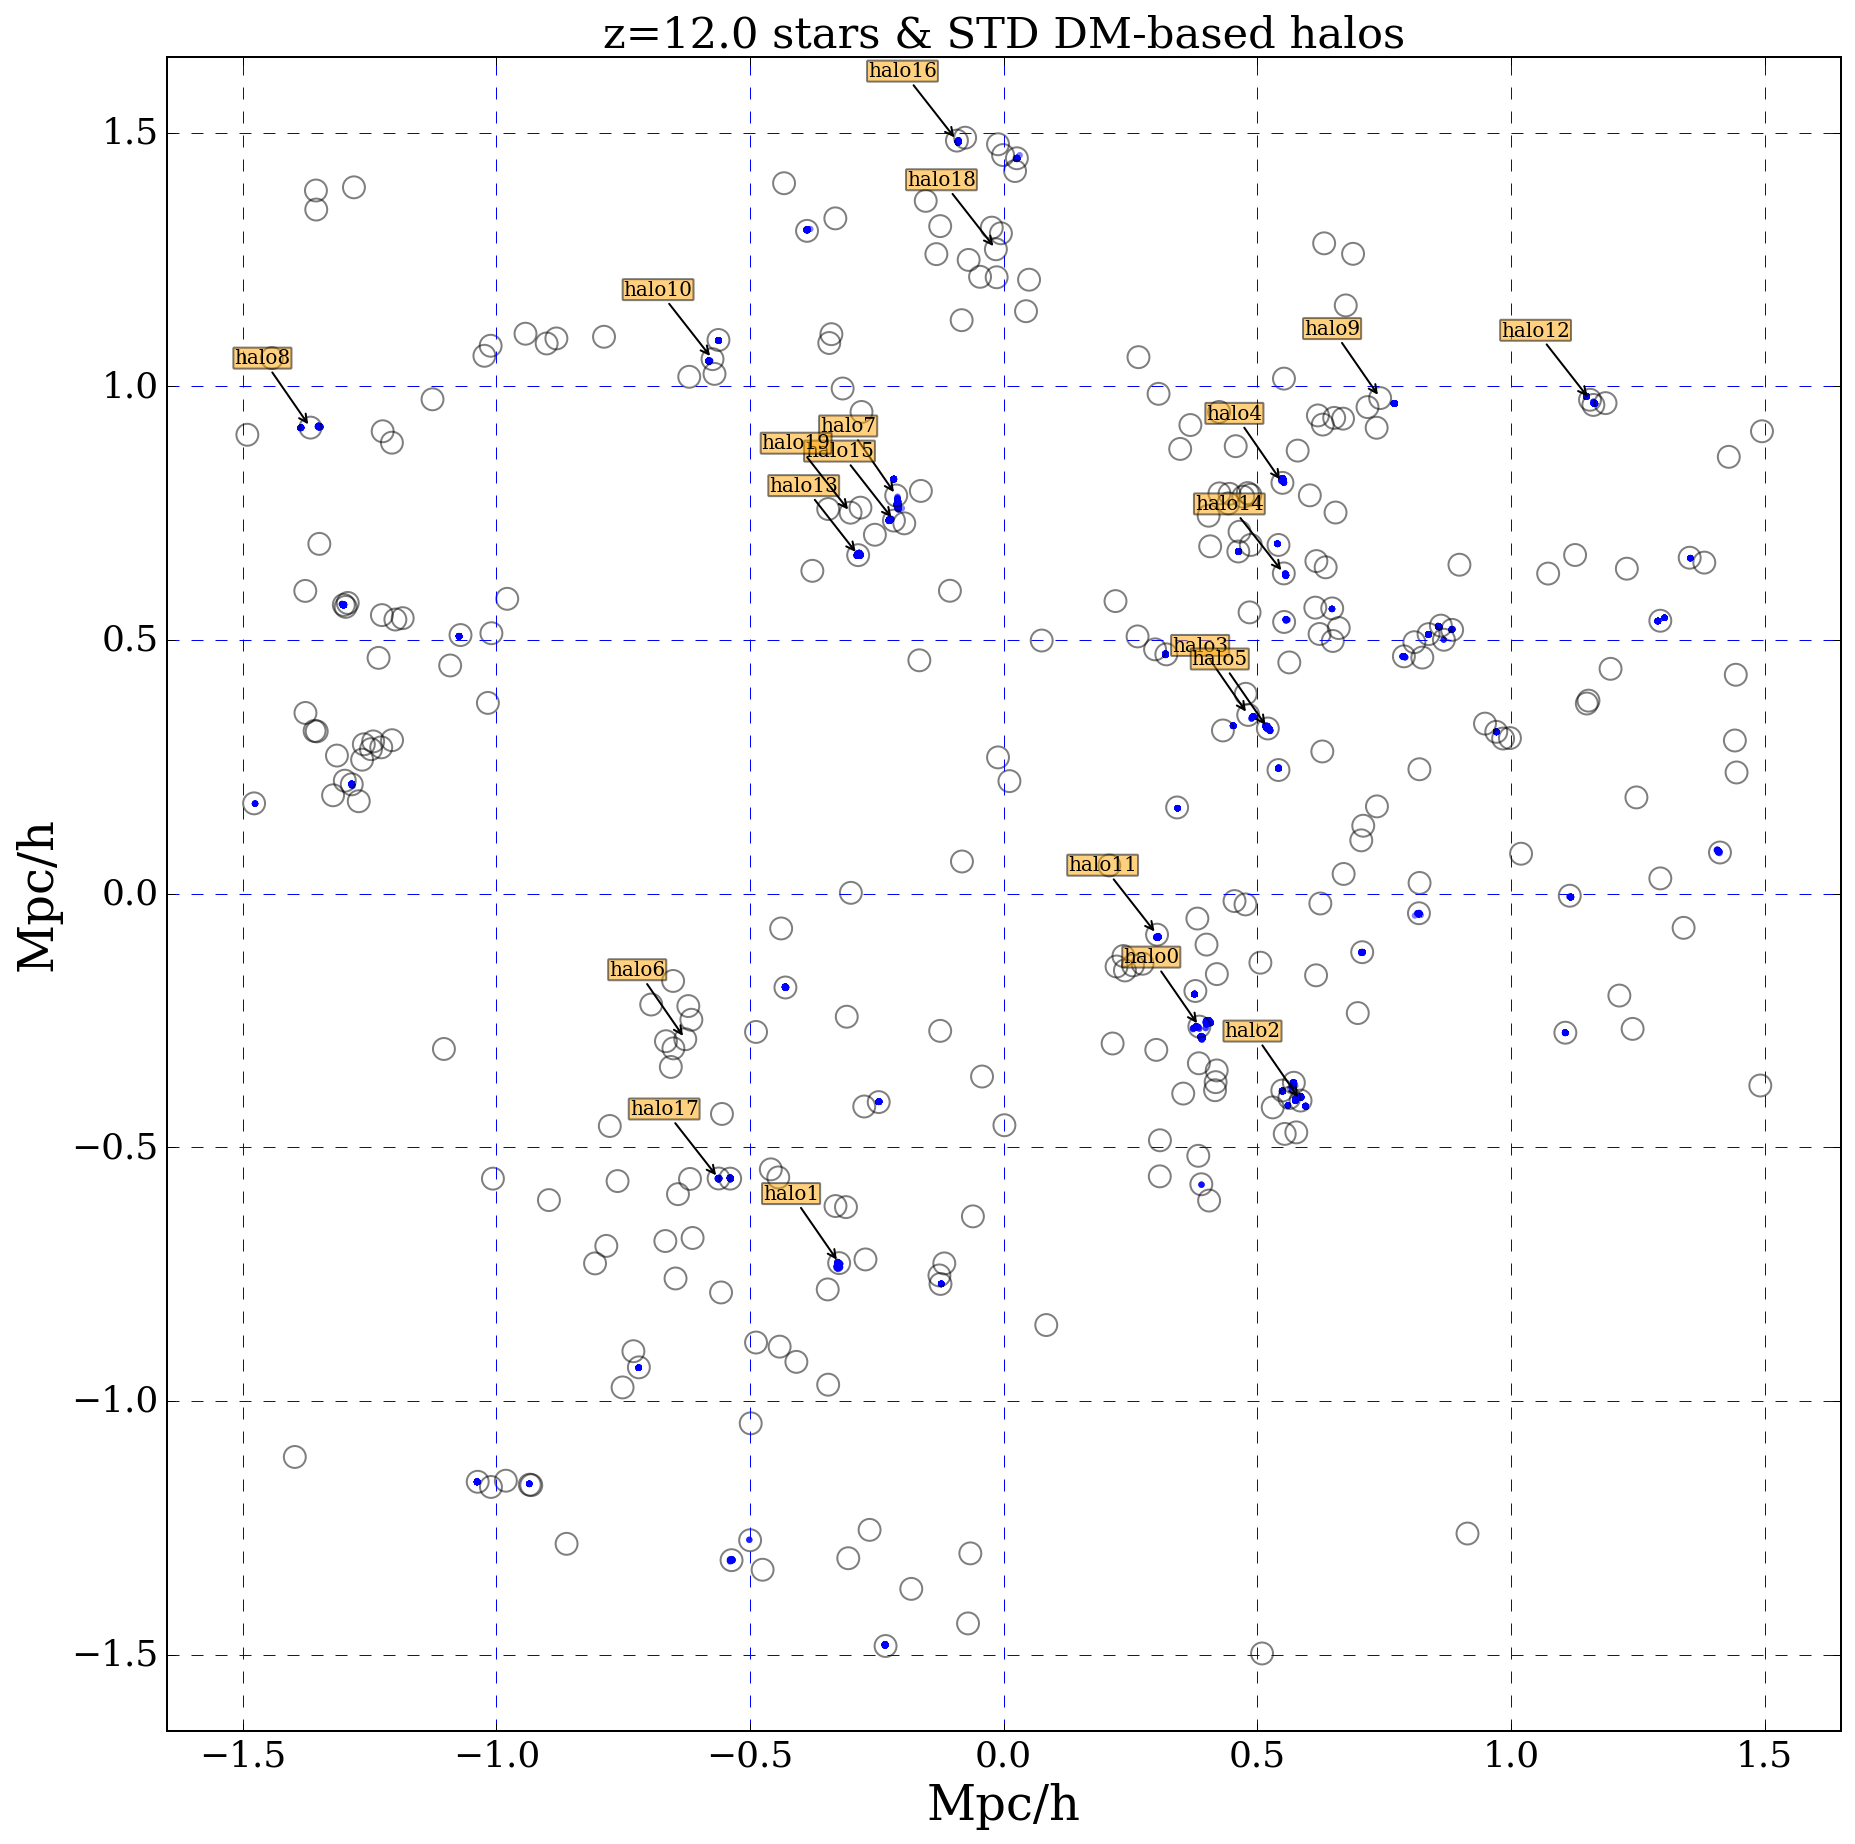

5811

In [108]:
htpSTDDM = 300 
print("number of halos",len(halosRawPosSTDDM))
plt.figure(figsize=(15,15))
# Generate a set of labels... 
labels = ['halo{0}'.format(i) for i in range(len(halosPosSTDDM))]

# Plot the star particle locations
plt.scatter(locs[:,0]/1000,locs[:,1]/1000,s=10,c='b',edgecolors='None', alpha=0.5) # Plot star particles

# Plot halo locations ... Convert to Mpc
plt.scatter(halosPosSTDDM[:htpSTDDM,0]/1000,halosPosSTDDM[:htpSTDDM,1]/1000,s=120,facecolors='none', edgecolors='k', alpha=0.5) # Plot halo locs

plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('Mpc/h',fontsize=24)
plt.ylabel('Mpc/h',fontsize=24)

plt.xlim([-1.65,1.65])
plt.ylim([-1.65,1.65])

plt.title('z=%.1lf stars & STD DM-based halos'%z)
for label, xSTDDM, ySTDDM in zip(labels, halosPosSTDDM[:htpSTDDM,0][:20]/1000,halosPosSTDDM[:htpSTDDM,1][:20]/1000):
    plt.annotate(
        label, 
        xy = (xSTDDM, ySTDDM), xytext = (-10, 30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'orange', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()
gc.collect()
 

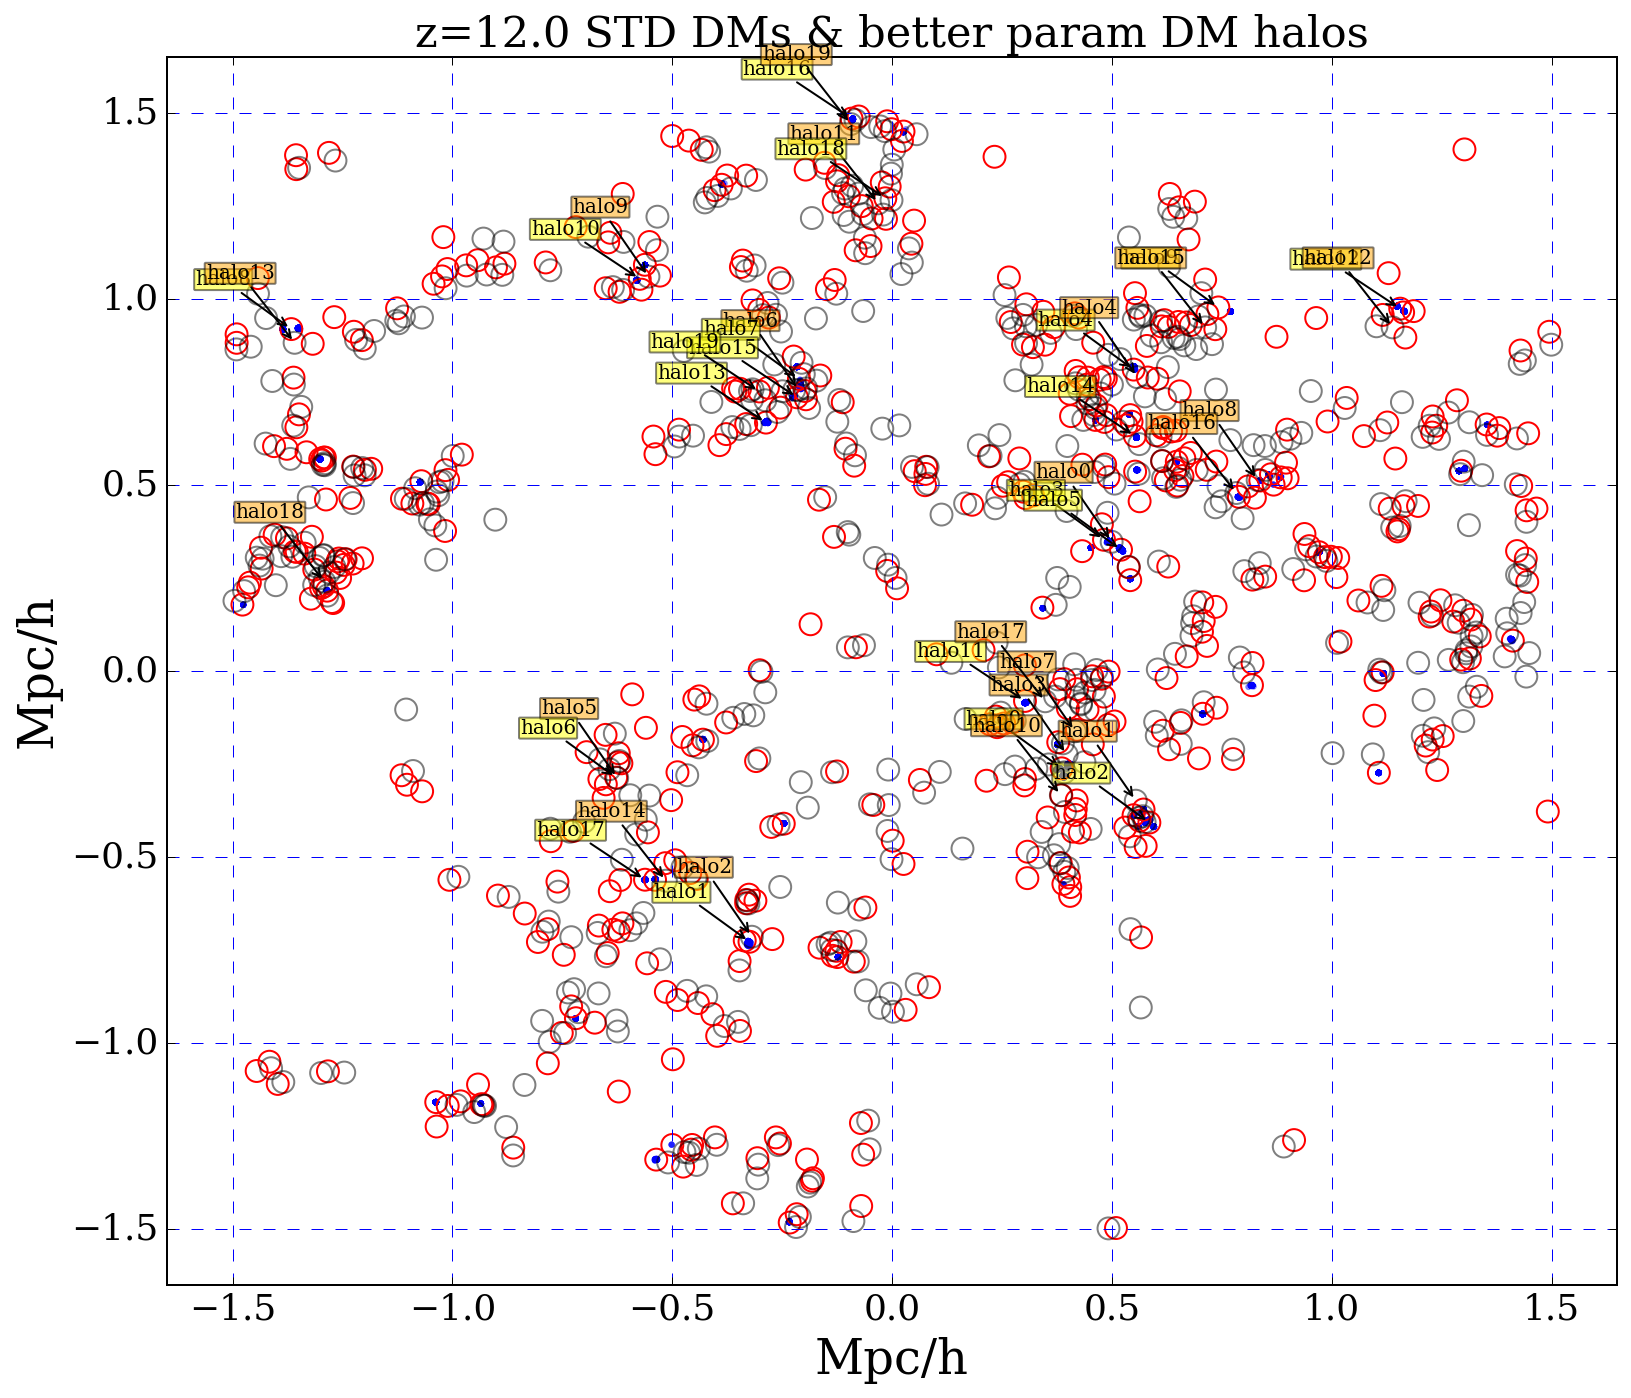

6943

In [109]:
htpDM    = 500

# Generate a set of labels... 
labels = ['halo{0}'.format(i) for i in range(len(halosPosDM))]

# Plot the STDDM particle locations
plt.scatter(locs[:,0]/1000,locs[:,1]/1000,s=10,c='b',edgecolors='None', alpha=0.5) # Plot STDDM particles

# Plot halo locations ... Convert to Mpc
plt.scatter(halosPosSTDDM[:htpDM,0]/1000,halosPosSTDDM[:htpDM,1]/1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.scatter(halosPosDM[:htpDM,0]/1000,halosPosDM[:htpDM,1]/1000,s=120,facecolors='none', edgecolors='k', alpha=0.5) # Plot halo locs

plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('Mpc/h',fontsize=24)
plt.ylabel('Mpc/h',fontsize=24)

plt.xlim([-1.65,1.65])
plt.ylim([-1.65,1.65])

plt.title('z=%.1lf STD DMs & better param DM halos'%z)
for label, xS, yS, xDM, yDM in zip(labels, halosPosSTDDM[:htpDM,0][:20]/1000,halosPosSTDDM[:htpDM,1][:20]/1000,
                          halosPosDM[:htpDM,0][:20]/1000,halosPosDM[:htpDM,1][:20]/1000):
    plt.annotate(
        label, 
        xy = (xS, yS), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.annotate(
        label, 
        xy = (xDM, yDM), xytext = (-10, 30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'orange', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()
gc.collect()
 

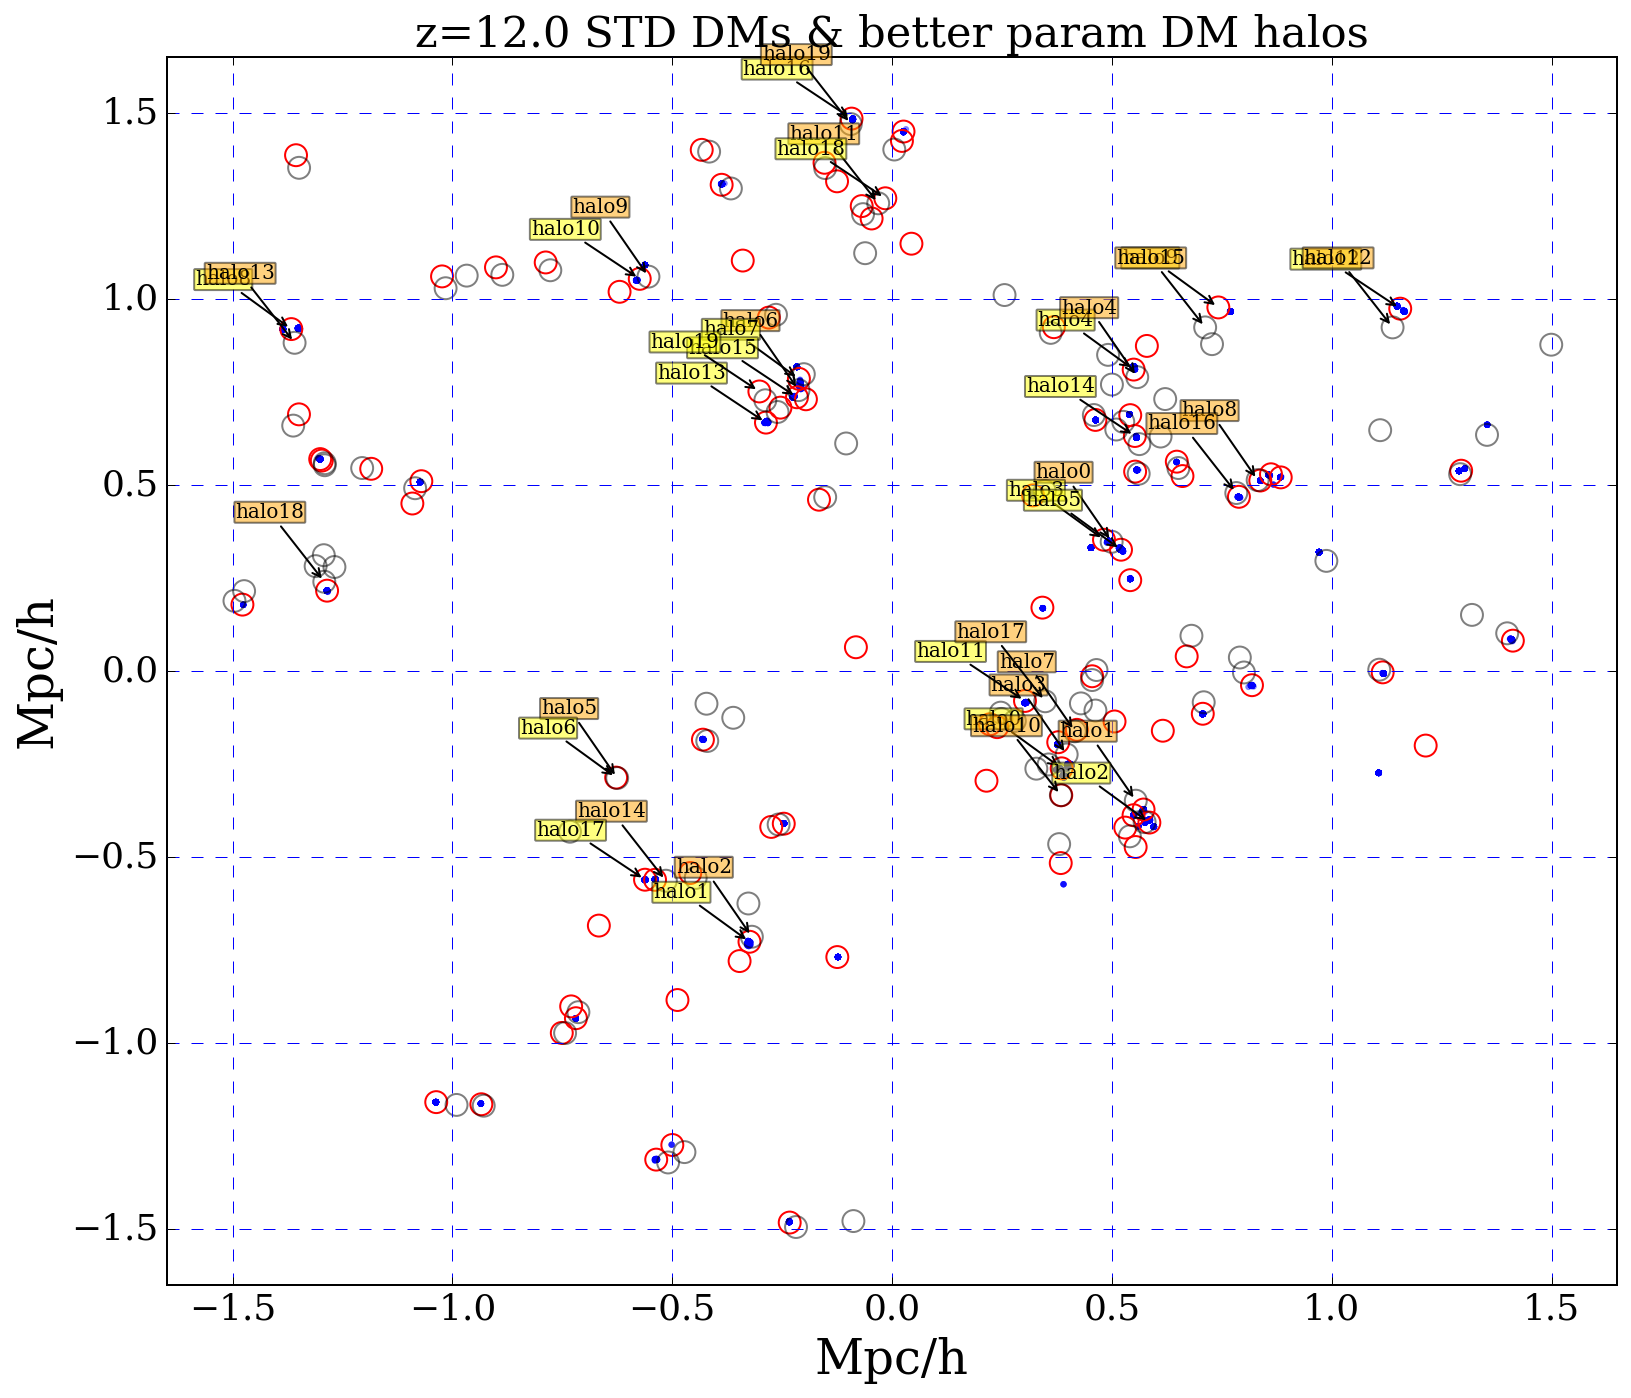

6943

In [110]:
htpDM    = 100

# Generate a set of labels... 
labels = ['halo{0}'.format(i) for i in range(len(halosPosDM))]

# Plot the STDDM particle locations
plt.scatter(locs[:,0]/1000,locs[:,1]/1000,s=10,c='b',edgecolors='None', alpha=0.5) # Plot STDDM particles

# Plot halo locations ... Convert to Mpc
plt.scatter(halosPosSTDDM[:htpDM,0]/1000,halosPosSTDDM[:htpDM,1]/1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.scatter(halosPosDM[:htpDM,0]/1000,halosPosDM[:htpDM,1]/1000,s=120,facecolors='none', edgecolors='k', alpha=0.5) # Plot halo locs

plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('Mpc/h',fontsize=24)
plt.ylabel('Mpc/h',fontsize=24)

plt.xlim([-1.65,1.65])
plt.ylim([-1.65,1.65])

plt.title('z=%.1lf STD DMs & better param DM halos'%z)
for label, xS, yS, xDM, yDM in zip(labels, halosPosSTDDM[:htpDM,0][:20]/1000,halosPosSTDDM[:htpDM,1][:20]/1000,
                          halosPosDM[:htpDM,0][:20]/1000,halosPosDM[:htpDM,1][:20]/1000):
    plt.annotate(
        label, 
        xy = (xS, yS), xytext = (-20, 20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
    plt.annotate(
        label, 
        xy = (xDM, yDM), xytext = (-10, 30),
        textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
        bbox = dict(boxstyle = 'round,pad=0.05', fc = 'orange', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()
gc.collect()
 